# Homework 4 - Multilayer Perceptron and Autoencoders on Financial Data

Author: Joshua Zhong

Assignment completed as part of NYU's FRE 7773 Machine Learning in Financial Engineering Course taught by Professor Amine Aboussalah

<br>

## Datasets

1. S&P 500 Historical Data - Yahoo Finance (for MLP stock movement prediction)
2. Credit Card Fraud Detection Dataset - Kaggle (for Autoencoder anomaly detection)

<br>

## Dependencies

In [18]:
# Import Numpy for Matrix Calculations
import numpy as np

# Import Pandas for Data Handling
import pandas as pd

# Import random for Base Python random functionality
import random

# Matplotlib library for plotting
import matplotlib.pyplot as plt

# Import yfinance for stock data
# !pip install yfinance
import yfinance as yf

## Task 1: Multilayer Perceptron for Stock Movement Prediction

### Objective

I will be implementing a basic feedforward neural network (Multilayer Perceptron) to predict next-day stock price movement (whether up or down) using historical S&P 500 data and engineered technical features. The implementation will include 2 hidden layers with ReLU activations and a Softmax output layer for binary classification.

### Implementation

A Multilayer Perceptron (MLP) is a feedforward neural network consisting of an input layer, one or more hidden layers, and an output layer. Each neuron in one layer is connected to all neurons in the subsequent layer. The MLP learns by adjusting its weights through a process called backpropagation, which computes gradients of the loss function with respect to each weight.

The forward pass computes the output by propagating inputs through each layer:
<center>$z^l = W^l a^{l-1} + b^l$</center>
<center>$a^l = g^l(z^l)$</center>
<br>
where $W^l$ is the weight matrix, $b^l$ is the bias vector, $z^l$ is the pre-activation, $a^l$ is the activation, and $g^l$ is the activation function for said layer l.

#### Model Architecture Design

For this stock prediction task: 

Input Layer -> Hidden Layer 1 -> Hidden Layer 2 -> Output Layer

The design choices were made as follows:

1. Number of Hidden Layers (2): I chose 2 hidden layers because this provides sufficient depth to learn non-linear relationships in the data without excessive complexity. A single hidden layer can theoretically approximate any function (Universal Approximation Theorem), but 2 layers allow the network to learn hierarchical features more efficiently. More than 2 layers would risk overfitting on our relatively simple feature set of 12 inputs.

2. Hidden Layer Sizes (64, 32): I used a "funnel" architecture where the first hidden layer is larger than the second. This allows the network to first expand the representation to capture diverse patterns, then compress it down to the most relevant features before classification. The sizes were chosen to be larger than our input dimension (12 features) but not excessively large to avoid overfitting.

3. ReLU Activation: ReLU (Rectified Linear Unit) was chosen for hidden layers because:
   - It mitigates the vanishing gradient problem that affects sigmoid/tanh
   - It introduces non-linearity while being computationally efficient
   - It promotes sparse activations which can help with generalization
   - It pairs well with He initialization, which is designed specifically for ReLU networks

4. Softmax Output: For binary classification, softmax provides interpretable probability outputs for each class (Up/Down), which is useful for understanding model confidence.

#### Activation Functions

For our MLP, we will use the ReLU (Rectified Linear Unit) activation function for the hidden layers and Softmax for the output layer.

ReLU is defined as:
<center>$\text{ReLU}(z) = \max(0, z)$</center>
<br>
The derivative of ReLU is:
<center>$\frac{d}{dz}\text{ReLU}(z) = \begin{cases} 1 & \text{if } z > 0 \\ 0 & \text{if } z \leq 0 \end{cases}$</center>
<br>

ReLU is preferred over sigmoid in hidden layers because it mitigates the vanishing gradient problem and allows for faster convergence.

Softmax is used for the output layer to convert raw scores into probabilities:
<center>$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$</center>

In [2]:
# Function that computes ReLU activation
def relu(z):
    # z represents the pre-activation values (can be an array or scalar)
    
    n = z.shape[0]  # Number of samples
    result = np.zeros_like(z)  # Initialize output array
    
    # Apply ReLU element-wise
    for i in range(n):
        for j in range(z.shape[1]):
            if z[i, j] > 0:
                result[i, j] = z[i, j]
            else:
                result[i, j] = 0.0
    
    return result  # Returns array with ReLU applied


# Function that computes derivative of ReLU activation
def relu_derivative(z):
    # z represents the pre-activation values
    
    n = z.shape[0]  # Number of samples
    result = np.zeros_like(z)  # Initialize output array
    
    # Apply ReLU derivative element-wise
    for i in range(n):
        for j in range(z.shape[1]):
            if z[i, j] > 0:
                result[i, j] = 1.0
            else:
                result[i, j] = 0.0
    
    return result  # Returns array with ReLU derivative


# Function that computes Softmax activation for output layer
def softmax(z):
    # z represents the pre-activation values of shape (n_samples, n_classes)
    
    n = z.shape[0]  # Number of samples
    n_classes = z.shape[1]  # Number of classes
    result = np.zeros_like(z)  # Initialize output array
    
    # Apply softmax row-wise (for each sample)
    for i in range(n):
        # Find max for numerical stability
        max_val = z[i, 0]
        for j in range(1, n_classes):
            if z[i, j] > max_val:
                max_val = z[i, j]
        
        # Compute exp(z - max) for each element
        exp_sum = 0.0
        for j in range(n_classes):
            result[i, j] = np.exp(z[i, j] - max_val)
            exp_sum += result[i, j]
        
        # Normalize by sum
        for j in range(n_classes):
            result[i, j] = result[i, j] / exp_sum
    
    return result  # Returns probability distribution over classes for each sample

#### Loss Function

For multi-class classification (even though we have binary classification, we use softmax output with 2 classes), we use the Cross-Entropy loss function:

<center>$\mathcal{L} = -\frac{1}{N}\sum_{i=1}^{N}\sum_{c=1}^{C} y_{i,c} \log(\hat{y}_{i,c})$</center>
<br>
where $N$ is the number of samples, $C$ is the number of classes, $y_{i,c}$ is 1 if sample $i$ belongs to class $c$ (one-hot encoded), and $\hat{y}_{i,c}$ is the predicted probability for class $c$.

In [13]:
# Function that computes cross-entropy loss 
def cross_entropy_loss(y_true, y_pred):
    # y_true represents the true labels of shape (n_samples, n_classes)
    # y_pred represents the predicted probabilities of shape (n_samples, n_classes)
    
    n = y_true.shape[0]  # Number of samples
    n_classes = y_true.shape[1]  # Number of classes
    epsilon = 1e-15  # Small value to prevent log(0) # Claude advised clipping
    
    total_loss = 0.0
    
    # Loop through each sample and class
    for i in range(n):
        for c in range(n_classes):
            # Clip prediction to prevent log(0)
            pred_clipped = y_pred[i, c]
            if pred_clipped < epsilon:
                pred_clipped = epsilon
            if pred_clipped > 1 - epsilon:
                pred_clipped = 1 - epsilon
            
            total_loss += -y_true[i, c] * np.log(pred_clipped)
    
    return total_loss / n  # Returns average cross-entropy loss

#### Weight Initialization

In [56]:
# Function to initialize weights with small random values
def initialize_weights(n_input, n_hidden1, n_hidden2, n_output):
    # n_input represents number of input features
    # n_hidden1 represents number of neurons in first hidden layer
    # n_hidden2 represents number of neurons in second hidden layer
    # n_output represents number of output classes
    
    # Initialize weights with small random values; produced terrible results
    # W1 = np.random.randn(n_input, n_hidden1) * 0.1
    # W2 = np.random.randn(n_hidden1, n_hidden2) * 0.1  
    # W3 = np.random.randn(n_hidden2, n_output) * 0.1

    # Initialize weights with He initialization
    W1 = np.random.randn(n_input, n_hidden1) * np.sqrt(2.0 / n_input)
    W2 = np.random.randn(n_hidden1, n_hidden2) * np.sqrt(2.0 / n_hidden1)
    W3 = np.random.randn(n_hidden2, n_output) * np.sqrt(2.0 / n_hidden2)

    
    b1 = np.zeros((1, n_hidden1))
    b2 = np.zeros((1, n_hidden2))
    b3 = np.zeros((1, n_output))
    
    # Store in dictionary for easy access
    parameters = {
        'W1': W1, 'b1': b1,
        'W2': W2, 'b2': b2,
        'W3': W3, 'b3': b3
    }
    
    return parameters  # Returns dictionary containing all weight matrices and bias vectors

#### Forward Propagation

Forward propagation computes the output of the network by passing input through each layer sequentially. For our 2-hidden-layer MLP:

Layer 1 (Input to Hidden 1):
<center>$z^{1} = X W^{1} + b^{1}$</center>
<center>$a^{1} = \text{ReLU}(z^{1})$</center>
<br>

Layer 2 (Hidden 1 → Hidden 2):
<center>$z^{2} = a^{1} W^{2} + b^{2}$</center>
<center>$a^{2} = \text{ReLU}(z^{2})$</center>
<br>

Layer 3 (Hidden 2 → Output):
<center>$z^{3} = a^{2} W^{3} + b^{3}$</center>
<center>$a^{3} = \text{Softmax}(z^{3})$</center>

In [7]:
# Function that performs forward propagation through the MLP
def forward_propagation(X, parameters):
    # X represents the input features of shape (n_samples, n_features)
    # parameters represents dictionary containing elements: W1, b1, W2, b2, W3, b3
    
    # Extract parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Layer 1: Input to Hidden 1
    z1 = X @ W1 + b1  # Linear transformation
    a1 = relu(z1)  # ReLU activation
    
    # Layer 2: Hidden 1 to Hidden 2
    z2 = a1 @ W2 + b2  # Linear transformation
    a2 = relu(z2)  # ReLU activation
    
    # Layer 3: Hidden 2 to Output
    z3 = a2 @ W3 + b3  # Linear transformation
    a3 = softmax(z3)  # Softmax activation for classification
    
    # Store intermediate values for backpropagation
    forward_result = {
        'z1': z1, 'a1': a1,
        'z2': z2, 'a2': a2,
        'z3': z3, 'a3': a3
    }
    
    return a3, forward_result  # Returns output probabilities and forward_result for backprop

#### Backward Propagation and Gradient Derivation

Backpropagation computes the gradients of the loss with respect to each parameter by applying the chain rule backward through the network. Here I will derive the gradients mathematically.

Gradient at Output Layer:

For cross-entropy loss with softmax, the gradient with respect to $z^{[3]}$ simplifies to:
<center>$\frac{\partial \mathcal{L}}{\partial z^{[3]}} = a^{[3]} - y$</center>
<br>
where $y$ is the one-hot encoded true label.

Let $\delta^{[3]} = a^{[3]} - y$, then:
<center>$\frac{\partial \mathcal{L}}{\partial W^{[3]}} = \frac{1}{N} (a^{[2]})^T \delta^{[3]}$</center>
<center>$\frac{\partial \mathcal{L}}{\partial b^{[3]}} = \frac{1}{N} \sum_{i=1}^{N} \delta^{[3]}_i$</center>

<br>

Gradient at Hidden Layer 2:

Propagate error back through the weights:
<center>$\delta^{[2]} = \delta^{[3]} (W^{[3]})^T \odot \text{ReLU}'(z^{[2]})$</center>
<br>
where $\odot$ represents element-wise multiplication.

<center>$\frac{\partial \mathcal{L}}{\partial W^{[2]}} = \frac{1}{N} (a^{[1]})^T \delta^{[2]}$</center>
<center>$\frac{\partial \mathcal{L}}{\partial b^{[2]}} = \frac{1}{N} \sum_{i=1}^{N} \delta^{[2]}_i$</center>

<br>

Gradient at Hidden Layer 1:

<center>$\delta^{[1]} = \delta^{[2]} (W^{[2]})^T \odot \text{ReLU}'(z^{[1]})$</center>
<center>$\frac{\partial \mathcal{L}}{\partial W^{[1]}} = \frac{1}{N} X^T \delta^{[1]}$</center>
<center>$\frac{\partial \mathcal{L}}{\partial b^{[1]}} = \frac{1}{N} \sum_{i=1}^{N} \delta^{[1]}_i$</center>



In [95]:
# Function that performs backward propagation to compute gradients
def backward_propagation(X, y_true, parameters, forward_result):
    # X represents the input features of shape (n_samples, n_features)
    # y_true represents labels of shape (n_samples, n_classes)
    # parameters represents dictionary containing W1, b1, W2, b2, W3, b3
    # forward_result represents dictionary containing z1, a1, z2, a2, z3, a3 from forward pass
    
    n = X.shape[0]  # Number of samples
    
    # Extract parameters
    W2 = parameters['W2']
    W3 = parameters['W3']
    
    # Extract values from forward pass dictionary
    z1 = forward_result['z1']
    a1 = forward_result['a1']
    z2 = forward_result['z2']
    a2 = forward_result['a2']
    a3 = forward_result['a3']  # Output probabilities
    
    # Output layer gradients (softmax + cross-entropy simplification)
    delta3 = a3 - y_true  # Shape: (n_samples, n_classes)
    
    dW3 = (a2.T @ delta3) / n
    
    # Compute db3
    db3 = np.zeros((1, delta3.shape[1]))
    for j in range(delta3.shape[1]):
        for i in range(n):
            db3[0, j] += delta3[i, j]
        db3[0, j] = db3[0, j] / n
    
    # Hidden layer 2 gradients
    delta2 = (delta3 @ W3.T) * relu_derivative(z2)
    
    dW2 = (a1.T @ delta2) / n
    
    # Compute db2
    db2 = np.zeros((1, delta2.shape[1]))
    for j in range(delta2.shape[1]):
        for i in range(n):
            db2[0, j] += delta2[i, j]
        db2[0, j] = db2[0, j] / n
    
    # Hidden layer 1 gradients
    delta1 = (delta2 @ W2.T) * relu_derivative(z1)
    
    dW1 = (X.T @ delta1) / n
    
    # Compute db1
    db1 = np.zeros((1, delta1.shape[1]))
    for j in range(delta1.shape[1]):
        for i in range(n):
            db1[0, j] += delta1[i, j]
        db1[0, j] = db1[0, j] / n
    
    gradients = {
        'dW1': dW1, 'db1': db1,
        'dW2': dW2, 'db2': db2,
        'dW3': dW3, 'db3': db3
    }
    
    return gradients  # Returns dictionary containing all gradients

After computing gradients, we update the parameters using gradient descent:
<center>$\theta = \theta - \alpha \nabla_{\theta} \mathcal{L}$</center>
<br>
where $\alpha$ is the learning rate.

In [10]:
# Function that updates parameters using gradient descent
def update_parameters(parameters, gradients, learning_rate):
    # parameters represents dictionary containing current W1, b1, W2, b2, W3, b3
    # gradients represents dictionary containing dW1, db1, dW2, db2, dW3, db3
    # learning_rate represents step size for gradient descent
    
    parameters['W1'] = parameters['W1'] - learning_rate * gradients['dW1']
    parameters['b1'] = parameters['b1'] - learning_rate * gradients['db1']
    parameters['W2'] = parameters['W2'] - learning_rate * gradients['dW2']
    parameters['b2'] = parameters['b2'] - learning_rate * gradients['db2']
    parameters['W3'] = parameters['W3'] - learning_rate * gradients['dW3']
    parameters['b3'] = parameters['b3'] - learning_rate * gradients['db3']
    
    return parameters  # Returns updated parameters dictionary

#### Training the MLP

Now I combine everything together into a complete training function that trains the MLP over multiple epochs, tracks both training and validation loss, and supports all the hyperparameters specified in the assignment.

In [12]:
# Function that trains the MLP
def train_mlp(X_train, y_train, X_val, y_val, n_hidden1, n_hidden2, learning_rate, epochs):
    # X_train represents training features
    # y_train represents training labels
    # X_val represents validation features
    # y_val represents validation labels
    # n_hidden1 represents number of neurons in first hidden layer
    # n_hidden2 represents number of neurons in second hidden layer
    # learning_rate represents step size for gradient descent
    # epochs represents number of training iterations over full dataset
    
    n_input = X_train.shape[1]  # Number of input features
    n_output = y_train.shape[1]  # Number of output classes
    
    # Initialize weights
    parameters = initialize_weights(n_input, n_hidden1, n_hidden2, n_output)
    
    # Track losses 
    train_losses = []
    val_losses = []
    
    # Training loop over epochs
    for epoch in range(epochs):
        # Forward propagation on full training set
        y_pred, forward_result = forward_propagation(X_train, parameters)
        
        # Backward propagation
        gradients = backward_propagation(X_train, y_train, parameters, forward_result)
        
        # Update parameters
        parameters = update_parameters(parameters, gradients, learning_rate)
        
        # Compute training loss
        train_loss = cross_entropy_loss(y_train, y_pred)
        train_losses.append(train_loss)
        
        # Compute validation loss
        y_val_pred, _ = forward_propagation(X_val, parameters)
        val_loss = cross_entropy_loss(y_val, y_val_pred)
        val_losses.append(val_loss)
    
    
    return parameters, train_losses, val_losses  # Returns trained parameters and loss history

#### Prediction Function

After training, I need a function to make predictions on new data by running forward propagation and selecting the class with the highest probability.

In [6]:
# Function that makes predictions using trained MLP
def predict(X, parameters):
    # X represents input features
    # parameters represents trained weights and biases
    
    # Get probabilities from forward pass
    probs, _ = forward_propagation(X, parameters)
    
    n = probs.shape[0]  # Number of samples
    predictions = np.zeros(n, dtype=int)
    
    # For each sample, find class with highest probability
    for i in range(n):
        max_prob = probs[i, 0]
        max_class = 0
        for j in range(1, probs.shape[1]):
            if probs[i, j] > max_prob:
                max_prob = probs[i, j]
                max_class = j
        predictions[i] = max_class
    
    return predictions  # Returns array of predicted class labels

#### Evaluation Metrics

I will implement functions to compute accuracy, precision, recall, F1-score, and confusion matrix.

- Accuracy: tells us the overall proportion of correct predictions (both Up and Down movements)
- Precision: indicates how many of our "Up" predictions were actually correct, important for trading strategies that only go long
- Recall: shows how many of the actual "Up" days we captured, relevant for not missing bullish opportunities
- F1-Score: provides a balanced measure between precision and recall
- Confusion Matrix: shows the breakdown of true/false positives and negatives

In [5]:
# Function that computes accuracy
def compute_accuracy(y_true, y_pred):
    # y_true represents the actual labels
    # y_pred represents the predicted labels
    
    correct = 0  # Counter for correct predictions
    total = len(y_true)  # Total number of samples
    
    # Count how many predictions match the actual labels
    for i in range(total):
        if y_true[i] == y_pred[i]:
            correct += 1
    
    accuracy = correct / total
    
    return accuracy  # Outputs accuracy as a float between 0 and 1


# Function that computes precision for binary classification
def compute_precision(y_true, y_pred):
    # y_true represents the actual labels
    # y_pred represents the predicted labels
    
    true_positives = 0
    false_positives = 0
    
    # Count true positives and false positives
    for i in range(len(y_true)):
        if y_pred[i] == 1:  # Model predicted positive
            if y_true[i] == 1:
                true_positives += 1
            else:
                false_positives += 1
    
    # Avoid division by zero
    if true_positives + false_positives == 0:
        return 0.0
    
    precision = true_positives / (true_positives + false_positives)
    
    return precision  # Outputs precision as a float between 0 and 1


# Function that computes recall for binary classification
def compute_recall(y_true, y_pred):
    # y_true represents the actual labels
    # y_pred represents the predicted labels
    
    true_positives = 0
    false_negatives = 0
    
    # Count true positives and false negatives
    for i in range(len(y_true)):
        if y_true[i] == 1:  # Actual positive
            if y_pred[i] == 1:
                true_positives += 1
            else:
                false_negatives += 1
    
    # Avoid division by zero
    if true_positives + false_negatives == 0:
        return 0.0
    
    recall = true_positives / (true_positives + false_negatives)
    
    return recall  # Outputs recall as a float between 0 and 1


# Function that computes F1-score
def compute_f1_score(y_true, y_pred):
    # y_true represents the actual labels
    # y_pred represents the predicted labels
    
    precision = compute_precision(y_true, y_pred)
    recall = compute_recall(y_true, y_pred)
    
    # Avoid division by zero
    if precision + recall == 0:
        return 0.0
    
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return f1  # Outputs F1 score as a float between 0 and 1


# Function that computes confusion matrix
def compute_confusion_matrix(y_true, y_pred):
    # y_true represents the actual labels
    # y_pred represents the predicted labels
    
    # For binary classification (2x2 matrix)
    confusion_matrix = np.zeros((2, 2))
    
    for i in range(len(y_true)):
        actual = int(y_true[i])
        predicted = int(y_pred[i])
        confusion_matrix[actual, predicted] += 1
    
    return confusion_matrix  # Returns 2x2 confusion matrix

### Application & Evaluation

Now we get to apply data to our MLP algorithm! I will load the S&P 500 data, engineer features, create labels, split the data, train the model, and evaluate its performance.

#### Load and Prepare S&P 500 Data

In [28]:
# Download S&P 500 index data (ticker: ^GSPC)
# Going back far enough to ensure we have 5000+ samples after feature engineering
# S&P 500 trades ~252 days per year, so ~20 years gives us plenty of data
sp500 = yf.download('^GSPC', start='2000-01-01', end='2025-12-01')

sp500.columns = sp500.columns.get_level_values(0)

# Reset index to make Date a column
sp500 = sp500.reset_index()

# EDA
print(sp500.shape)
print(sp500.head())
print(sp500.tail())

/var/folders/dk/pzmx27fj0198nc95vcbfwgn00000gn/T/ipykernel_2511/3419624704.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start='2000-01-01', end='2025-12-01')
[*********************100%***********************]  1 of 1 completed

(6517, 6)
Price       Date        Close         High          Low         Open  \
0     2000-01-03  1455.219971  1478.000000  1438.359985  1469.250000   
1     2000-01-04  1399.420044  1455.219971  1397.430054  1455.219971   
2     2000-01-05  1402.109985  1413.270020  1377.680054  1399.420044   
3     2000-01-06  1403.449951  1411.900024  1392.099976  1402.109985   
4     2000-01-07  1441.469971  1441.469971  1400.729980  1403.449951   

Price      Volume  
0       931800000  
1      1009000000  
2      1085500000  
3      1092300000  
4      1225200000  
Price       Date        Close         High          Low         Open  \
6512  2025-11-21  6602.990234  6660.049805  6521.919922  6555.770020   
6513  2025-11-24  6705.120117  6715.750000  6630.700195  6636.540039   
6514  2025-11-25  6765.879883  6776.399902  6659.979980  6697.029785   
6515  2025-11-26  6812.609863  6831.439941  6783.870117  6793.549805   
6516  2025-11-28  6849.089844  6850.859863  6819.750000  6822.520020   

Pric

#### Feature Engineering

I will engineer the following features:
- Previous 5-10 days returns
- Simple Moving Averages
- Encode label as Next-day movement (Up=1, Down=0)

In [34]:
# Function to engineer features for stock prediction
def engineer_features(data, lookback=10):
    # data represents the stock price dataframe with 'Close' column from yfinance
    # lookback represents the number of previous days to use for features
    
    prices = data['Close'].values
    n = len(prices)
    
    features = []
    labels = []
    
    # Loop through data starting from lookback day
    for i in range(lookback, n - 1):  # -1 because we need next day for label
        feature_row = []
        
        # Previous returns (days 1 through lookback)
        for j in range(1, lookback + 1):
            # Daily return = (price_t - price_t-1) / price_t-1
            ret = (prices[i - j + 1] - prices[i - j]) / prices[i - j]
            feature_row.append(ret)
        
        # Simple Moving Averages
        # 5-day SMA ratio to current price
        sma_5 = 0.0
        for k in range(5):
            sma_5 += prices[i - k]
        sma_5 = sma_5 / 5
        sma_5_ratio = (prices[i] - sma_5) / sma_5
        feature_row.append(sma_5_ratio)
        
        # 10-day SMA ratio to current price
        sma_10 = 0.0
        for k in range(10):
            sma_10 += prices[i - k]
        sma_10 = sma_10 / 10
        sma_10_ratio = (prices[i] - sma_10) / sma_10
        feature_row.append(sma_10_ratio)
        
        features.append(feature_row)
        
        # Label: 1 if next day price is higher, 0 otherwise
        if prices[i + 1] > prices[i]:
            labels.append(1)
        else:
            labels.append(0)
    
    X = np.array(features)
    y = np.array(labels)
    
    return X, y  # Returns feature matrix and labels array

In [37]:
# Engineer features
X, y = engineer_features(sp500, lookback=10)

# Use first 5000 samples as per assignment
if X.shape[0] > 5000:
    X = X[:5000]
    y = y[:5000]

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

Feature matrix shape: (5000, 12)
Labels shape: (5000,)


#### Data Splitting

We will now perform train/validation/test data splitting into 60% training, 20% validation, and 20% test sets

In [38]:
# Function that splits data into train/val/test sets (from previous homework)
def train_val_test_split(X, y, train_ratio=0.60, val_ratio=0.20, test_ratio=0.20, random_seed=None):
    # X represents the feature matrix size number of samples by number of features
    # y represents the target vector with length equal to number of samples
    # train_ratio represents the proportion of data allocated to training set
    # val_ratio represents the proportion of data allocated to validation set
    # test_ratio represents the proportion of data allocated to test set
    # random_seed is an optional parameter for reproducibility

    # Verify that the ratios sum to 1.0
    total_ratio = train_ratio + val_ratio + test_ratio
    if abs(total_ratio - 1.0) > 1e-6:
        raise ValueError("Error: Ratios must sum to 1.0")
    
    # Set random seed if provided for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n = X.shape[0]  # Total number of samples
    
    # Create array of indices from 0 to n-1 and shuffle them randomly
    indices = np.arange(n)
    np.random.shuffle(indices)  # In-place randomization

    # Calculate the split points based on ratios
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    
    # Split the indices into three groups
    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]
    
    # Apply the shuffled indices to X and y to create the splits
    X_train = X[train_indices]
    X_val = X[val_indices]
    X_test = X[test_indices]
    
    y_train = y[train_indices]
    y_val = y[val_indices]
    y_test = y[test_indices]
    
    return X_train, X_val, X_test, y_train, y_val, y_test  # Outputs the split datasets

In [39]:
# Split the data
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X, y, train_ratio=0.60, val_ratio=0.20, test_ratio=0.20, random_seed=88
)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 3000
Validation set size: 1000
Test set size: 1000


#### Feature Normalization

Neural networks perform better when input features are normalized. I will standardize the features to have mean 0 and standard deviation 1, using only training set statistics to prevent data leakage.

In [40]:
# Function that normalizes features using training statistics
def normalize_features(X_train, X_val, X_test):
    # X_train represents training features
    # X_val represents validation features
    # X_test represents test features
    
    n_train = X_train.shape[0]
    n_features = X_train.shape[1]
    
    # Compute mean and std from training set only
    means = np.zeros(n_features)
    stds = np.zeros(n_features)
    
    for j in range(n_features):
        # Compute mean
        total = 0.0
        for i in range(n_train):
            total += X_train[i, j]
        means[j] = total / n_train
        
        # Compute std
        variance = 0.0
        for i in range(n_train):
            variance += (X_train[i, j] - means[j]) ** 2
        stds[j] = np.sqrt(variance / n_train)
    
    # Normalize training set
    X_train_norm = np.zeros_like(X_train)
    for j in range(n_features):
        for i in range(n_train):
            if stds[j] > 1e-8:
                X_train_norm[i, j] = (X_train[i, j] - means[j]) / stds[j]
            else:
                X_train_norm[i, j] = 0.0
    
    # Normalize validation set using training statistics
    n_val = X_val.shape[0]
    X_val_norm = np.zeros_like(X_val)
    for j in range(n_features):
        for i in range(n_val):
            if stds[j] > 1e-8:
                X_val_norm[i, j] = (X_val[i, j] - means[j]) / stds[j]
            else:
                X_val_norm[i, j] = 0.0
    
    # Normalize test set using training statistics
    n_test = X_test.shape[0]
    X_test_norm = np.zeros_like(X_test)
    for j in range(n_features):
        for i in range(n_test):
            if stds[j] > 1e-8:
                X_test_norm[i, j] = (X_test[i, j] - means[j]) / stds[j]
            else:
                X_test_norm[i, j] = 0.0
    
    return X_train_norm, X_val_norm, X_test_norm  # Returns normalized datasets

In [41]:
# Normalize the features
X_train_norm, X_val_norm, X_test_norm = normalize_features(X_train, X_val, X_test)

print("Normalized training features shape:", X_train_norm.shape)

Normalized training features shape: (3000, 12)


#### One Hot Encoding

In [42]:
# Function to convert labels to one-hot encoded
def one_hot_encode(y, n_classes=2):
    # y represents array of integer labels
    # n_classes represents number of classes
    
    n = len(y)
    one_hot = np.zeros((n, n_classes))
    
    for i in range(n):
        one_hot[i, int(y[i])] = 1.0
    
    return one_hot  # Returns encoded array

In [43]:
# Apply one hot encoding
y_train_onehot = one_hot_encode(y_train)
y_val_onehot = one_hot_encode(y_val)
y_test_onehot = one_hot_encode(y_test)

#### Hyperparameter Selection 

Choosing appropriate hyperparameters can significantly affect neural network training. This is the rationale for why we're working with thses hyperparameters for our baseline :

Learning Rate (0.01): The learning rate controls how much we adjust weights in response to gradients. I selected 0.01 as a starting point because:
- Too high (e.g., 0.1+) can cause the optimization to overshoot and diverge
- Too low (e.g., 0.0001) leads to very slow convergence
- 0.01 is a commonly used default that provides a balance between speed and stability

Hidden Layer Sizes (64, 32): These sizes were chosen based on the following considerations:
- Our input has 12 features, so hidden layers should be larger to allow the network to learn complex combinations
- The funnel shape (64 → 32) progressively compresses information toward the binary output
- These sizes are small enough to train quickly on 5000 samples without severe overfitting

Number of Epochs (100): An epoch is one complete pass through the training data. I chose 100 epochs to:
- Allow sufficient time for the loss to converge
- Monitor for overfitting by comparing training and validation loss
- Balance training time with model performance

Weight Initialization (He Initialization): Weights are initialized using He initialization, which draws from a normal distribution scaled by the layer's input size:

<center>$W^{[l]} \sim \mathcal{N}\left(0, \sqrt{\frac{2}{n^{[l-1]}}}\right)$</center>
<br>

He initialization is specifically designed for ReLU activations. The scaling factor $\sqrt{2/n}$ accounts for the fact that ReLU sets roughly half of the activations to zero, so we need larger initial weights to maintain variance through the forward pass. This prevents:
- Vanishing activations (outputs collapsing to similar values)
- Exploding activations (outputs growing uncontrollably)
  
I will also experiment later with different values of these hyperparameters to assess their impact on model performance.

#### Training Baseline Model

Now for the fun part! We will train the MLP with specified set of hyperparameters. I'll start with a baseline configuration and then experiment with different settings.

In [57]:
# Set random seed for reproducibility
random.seed(88)
np.random.seed(88)

# Define hyperparameters
n_hidden1 = 64  # Number of neurons in first hidden layer
n_hidden2 = 32  # Number of neurons in second hidden layer
learning_rate = 0.01  # Step size for gradient descent
epochs = 100  # Number of training iterations

# Train the model
parameters, train_losses, val_losses = train_mlp(
    X_train_norm, y_train_onehot,
    X_val_norm, y_val_onehot,
    n_hidden1, n_hidden2,
    learning_rate, epochs
)

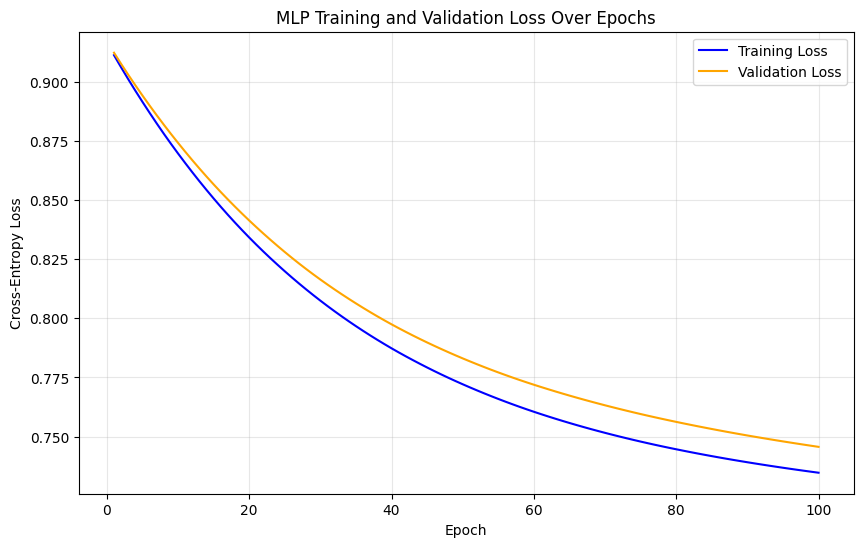

In [58]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('MLP Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [59]:
# Make predictions on test set
y_test_pred = predict(X_test_norm, parameters)

# Calculate evaluation metrics
accuracy = compute_accuracy(y_test, y_test_pred)
precision = compute_precision(y_test, y_test_pred)
recall = compute_recall(y_test, y_test_pred)
f1 = compute_f1_score(y_test, y_test_pred)
confusion_mat = compute_confusion_matrix(y_test, y_test_pred)

# Print results
print("Baseline Test Set Evaluation Results:")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)
print("Confusion Matrix:")
print(confusion_mat)

Baseline Test Set Evaluation Results:
Accuracy:  0.506
Precision:  0.5294117647058824
Recall:  0.5954631379962193
F1-Score:  0.5604982206405694
Confusion Matrix:
[[191. 280.]
 [214. 315.]]


So this model is performing really poorly. It's also clearly not a problem with class balance as it's relatively well balanced. Based off of the visualizations, the training and validation losses are decreasing, so the algorithm itself is working. 

Let's try playing around with different hyperparameters to see if that may help.

In [48]:
print("Training set - Up:", sum(y_train), "Down:", len(y_train) - sum(y_train))

Training set - Up: 1611 Down: 1389


In [60]:
print("Prediction distribution:", sum(y_test_pred), "Up,", len(y_test_pred) - sum(y_test_pred), "Down")

Prediction distribution: 595 Up, 405 Down


#### Hyperparameter Experiments

Because our baseline model performed so poorly, let's try to experiment with different hyperparameters to see how they affect model performance.

In [71]:
# Experiment with different configurations
experiments = [
    {'n_hidden1': 32, 'n_hidden2': 16, 'learning_rate': 0.01, 'epochs': 100},
    {'n_hidden1': 64, 'n_hidden2': 32, 'learning_rate': 0.001, 'epochs': 100},
    {'n_hidden1': 128, 'n_hidden2': 64, 'learning_rate': 0.01, 'epochs': 150},
]

results = []

for exp in experiments:
    print("\nExperiment: Hidden Layer 1: ", exp['n_hidden1'], "Hidden Layer 2: ", exp['n_hidden2'], 
          "Learning Rate: ", exp['learning_rate'], "Number of Epochs: ", exp['epochs'])
    
    # Reproducible seed
    random.seed(88)
    np.random.seed(88)
    
    # Train
    params, train_loss, val_loss = train_mlp(X_train_norm, y_train_onehot, X_val_norm, y_val_onehot,
        exp['n_hidden1'], exp['n_hidden2'], exp['learning_rate'], exp['epochs'])
    
    # Evaluate
    y_pred = predict(X_test_norm, params)
    acc = compute_accuracy(y_test, y_pred)
    prec = compute_precision(y_test, y_pred)
    rec = compute_recall(y_test, y_pred)
    f1_exp = compute_f1_score(y_test, y_pred)
    confusion_mat = compute_confusion_matrix(y_test, y_pred)

    
    results.append({
        'config': exp,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1_exp,  
        'train_losses': train_loss,
        'val_losses': val_loss
    })
    
    print("Test Accuracy: ", acc, "Precision: ", prec, "Recall: ", rec, "F1-Score: ",f1_exp, "Confusion Matrix: ", confusion_mat)


Experiment: Hidden Layer 1:  32 Hidden Layer 2:  16 Learning Rate:  0.01 Number of Epochs:  100
Test Accuracy:  0.494 Precision:  0.5196581196581197 Recall:  0.5746691871455577 F1-Score:  0.5457809694793537 Confusion Matrix:  [[190. 281.]
 [225. 304.]]

Experiment: Hidden Layer 1:  64 Hidden Layer 2:  32 Learning Rate:  0.001 Number of Epochs:  100
Test Accuracy:  0.512 Precision:  0.5377532228360957 Recall:  0.5519848771266541 F1-Score:  0.5447761194029852 Confusion Matrix:  [[220. 251.]
 [237. 292.]]

Experiment: Hidden Layer 1:  128 Hidden Layer 2:  64 Learning Rate:  0.01 Number of Epochs:  150
Test Accuracy:  0.506 Precision:  0.5297113752122241 Recall:  0.5897920604914934 F1-Score:  0.5581395348837209 Confusion Matrix:  [[194. 277.]
 [217. 312.]]


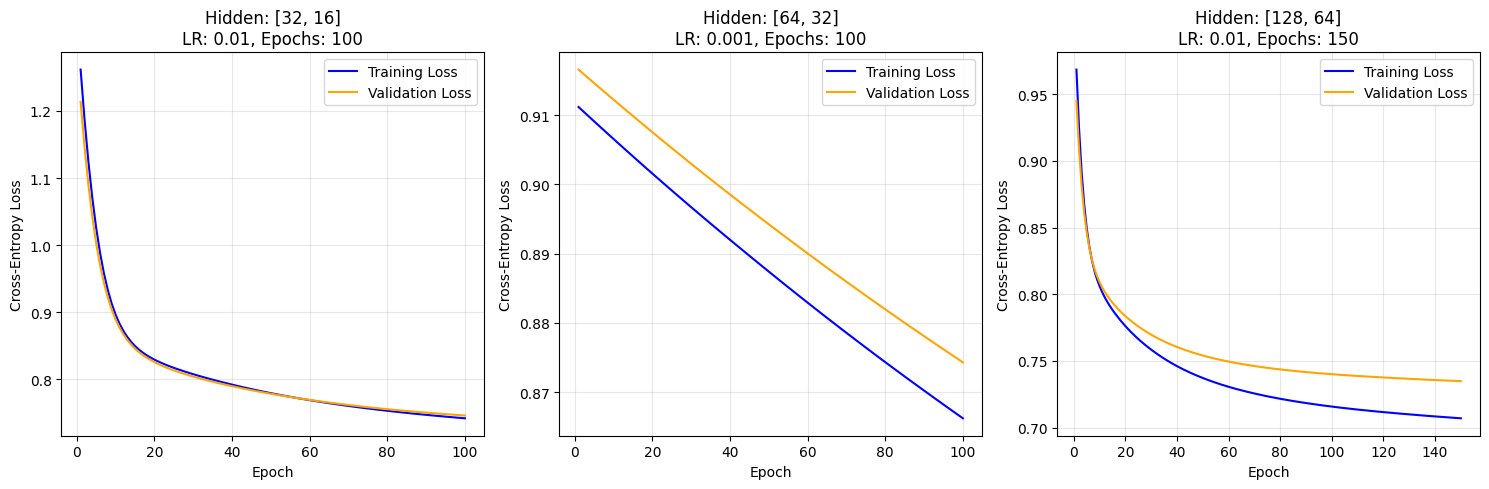

In [69]:
# Plot training and validation loss for each experiment; Claude
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, result in enumerate(results):
    config = result['config']
    train_losses = result['train_losses']
    val_losses = result['val_losses']
    epochs = config['epochs']
    
    axes[i].plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
    axes[i].plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='orange')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Cross-Entropy Loss')
    axes[i].set_title(f"Hidden: [{config['n_hidden1']}, {config['n_hidden2']}]\nLR: {config['learning_rate']}, Epochs: {epochs}")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Interpretation and Analysis

Overfitting vs Underfitting Analysis:

By comparing the training and validation loss curves:
- If training loss continues to decrease while validation loss starts increasing, this indicates overfitting as the model is memorizing training data rather than learning generalizable patterns. The model is not complex enough to capture the underlying patterns
- The ideal scenario is when both losses decrease together and converge to similar low values

Out of all of the plots, it appears the experiment with [32,16] has the best convergence and the least gap between the training and validation loss curves. 

Key Observations:

1) All models perform similarly (~50-51% accuracy): This is expected for stock prediction tasks. The efficient market hypothesis suggests that historical price patterns contain limited predictive information, making accuracy much above 50% difficult to achieve.
2) The smaller network [32,16] performs worst with evaluation metrics but best learning curve: The learning curves converges closely (which indicates good generalization) but has the lowest test accuracy (49.4%). This suggests the model may be underfitting and can't capture the predictive signal of our features. 
3) Larger network [128,64] has poor learning curves but good evaluation metrics: The plot demonstrates overfitting with the validation loss being higher than the training loss, but it has the best evaluation metrics (accuracy of 50.6% and highest F1-score). Now, this improvement seems marginal to the small network, so that improvement of generalizability may still mean the small network is better. 
4) Lower learning rate (0.001) achieves highest accuracy (51.2%): The slower learning rate allows for more stable convergence and better precision (0.538), though at the cost of recall (0.552). This suggests the baseline learning rate of 0.01 may cause the model to overshoot optimal weights. HOWEVER, it appears as though it is overfit, but it potentially may converge in the long run. 
I believe that in the future, using more epochs *could potentially* yield better results. 
5) Precision-Recall tradeoff: The baseline and larger network favor recall (catching more "Up" movements), while the lower learning rate configuration balances precision and recall more evenly.

Conclusion: 

The model architecture seems to have minimal impact on performance for this task. The results suggest that the engineered features (past returns and SMAs) provide limited signal for next-day prediction, which aligns with financial theory. Although, it appears as though a model with 100 epochs, learning rate of 0.01, and either a network of [64,32] or [32,16] seem to perform the best. 

## Task 3: Autoencoder for Fraud Detection

### Objective

I will implement an autoencoder to detect fraudulent credit card transactions by learning compact feature representations. The key insight is that when we train only on normal transactions, the autoencoder becomes very good at reconstructing normal patterns but bad at reconstructing unfamiliar, anomalous patterns like fraud.

### Implementation

An autoencoder is a neural network that learns to compress data into a lower-dimensional representation (encoding) and then reconstruct the original data from this compressed representation (decoding). The network consists of:

1. **Encoder**: Compresses input to a latent (hidden) representation
2. **Latent Space**: The compressed representation (bottleneck)
3. **Decoder**: Reconstructs the input from the latent representation

The architecture is symmetric - if the encoder has layers of size [input, h1, latent], the decoder has [latent, h1, output].

The loss function is Mean Squared Error (MSE) between input and reconstruction:
<center>$\mathcal{L} = \frac{1}{N}\sum_{i=1}^{N}||x_i - \hat{x}_i||^2 = \frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{D}(x_{i,j} - \hat{x}_{i,j})^2$</center>
<br>
where $x_i$ is the input and $\hat{x}_i$ is the reconstruction.

#### Encoder

The encoder compresses the input through 1-2 hidden layers with ReLU activations down to the latent space.

In [72]:
# Function to initialize autoencoder weights
def initialize_autoencoder_weights(n_input, n_hidden1, n_latent, n_hidden2, n_output):
    # n_input represents number of input features
    # n_hidden1 represents number of neurons in encoder hidden layer
    # n_latent represents dimension of latent space (configurable)
    # n_hidden2 represents number of neurons in decoder hidden layer (symmetric to n_hidden1)
    # n_output represents number of output features (same as n_input for autoencoder)
    
    # Encoder weights with small random values
    W_enc1 = np.random.randn(n_input, n_hidden1) * 0.01
    b_enc1 = np.zeros((1, n_hidden1))
    
    W_enc2 = np.random.randn(n_hidden1, n_latent) * 0.01
    b_enc2 = np.zeros((1, n_latent))
    
    # Decoder weights (symmetric architecture)
    W_dec1 = np.random.randn(n_latent, n_hidden2) * 0.01
    b_dec1 = np.zeros((1, n_hidden2))
    
    W_dec2 = np.random.randn(n_hidden2, n_output) * 0.01
    b_dec2 = np.zeros((1, n_output))
    
    parameters = {
        'W_enc1': W_enc1, 'b_enc1': b_enc1,
        'W_enc2': W_enc2, 'b_enc2': b_enc2,
        'W_dec1': W_dec1, 'b_dec1': b_dec1,
        'W_dec2': W_dec2, 'b_dec2': b_dec2
    }
    
    return parameters  # Returns dictionary containing encoder and decoder weights

#### Forward Pass (Encode + Decode)

In [73]:
# Function that performs forward pass through the autoencoder
def autoencoder_forward(X, parameters):
    # X represents input features
    # parameters represents dictionary with encoder and decoder weights
    
    # Extract encoder parameters
    W_enc1 = parameters['W_enc1']
    b_enc1 = parameters['b_enc1']
    W_enc2 = parameters['W_enc2']
    b_enc2 = parameters['b_enc2']
    
    # Extract decoder parameters
    W_dec1 = parameters['W_dec1']
    b_dec1 = parameters['b_dec1']
    W_dec2 = parameters['W_dec2']
    b_dec2 = parameters['b_dec2']
    
    # Encoder forward pass
    z_enc1 = X @ W_enc1 + b_enc1
    a_enc1 = relu(z_enc1)  # Hidden layer 1 with ReLU (reuse ReLU from Task 1)
    
    z_enc2 = a_enc1 @ W_enc2 + b_enc2
    latent = relu(z_enc2)  # Latent representation with ReLU
    
    # Decoder forward pass
    z_dec1 = latent @ W_dec1 + b_dec1
    a_dec1 = relu(z_dec1)  # Hidden layer with ReLU
    
    z_dec2 = a_dec1 @ W_dec2 + b_dec2
    reconstruction = z_dec2  # Linear output for reconstruction
    
    # Store forward results for backpropagation
    forward_results = {
        'z_enc1': z_enc1, 'a_enc1': a_enc1,
        'z_enc2': z_enc2, 'latent': latent,
        'z_dec1': z_dec1, 'a_dec1': a_dec1,
        'z_dec2': z_dec2, 'reconstruction': reconstruction
    }
    
    return reconstruction, forward_results  # Returns reconstruction and forward pass

#### MSE Loss Function

In [74]:
# Function that computes Mean Squared Error loss
def mse_loss(X_true, X_reconstructed):
    # X_true represents the original input
    # X_reconstructed represents the autoencoder reconstruction
    
    n = X_true.shape[0]  # Number of samples
    d = X_true.shape[1]  # Number of features
    
    total_loss = 0.0
    
    # Compute MSE
    for i in range(n):
        for j in range(d):
            total_loss += (X_true[i, j] - X_reconstructed[i, j]) ** 2
    
    return total_loss / (n * d)  # Returns average MSE


# Function that computes reconstruction error per sample (for anomaly detection)
def compute_reconstruction_error(X_true, X_reconstructed):
    # X_true represents the original input
    # X_reconstructed represents the autoencoder reconstruction
    
    n = X_true.shape[0]  # Number of samples
    d = X_true.shape[1]  # Number of features
    
    errors = np.zeros(n)
    
    # Compute MSE for each sample
    for i in range(n):
        sample_error = 0.0
        for j in range(d):
            sample_error += (X_true[i, j] - X_reconstructed[i, j]) ** 2
        errors[i] = sample_error / d
    
    return errors  # Returns array of reconstruction errors

#### Backward Propagation for Autoencoder

For the autoencoder, backpropagation works similarly to the MLP but with MSE loss instead of cross-entropy. The gradient of MSE with respect to the output is:

<center>$\frac{\partial \mathcal{L}}{\partial \hat{x}} = \frac{2}{N \cdot D}(\hat{x} - x)$</center>
<br>
We then backpropagate through the decoder and encoder layers using the chain rule.

In [75]:
# Function that performs backward propagation for autoencoder
def autoencoder_backward(X, parameters, forward_results):
    # X represents original input
    # parameters represents dictionary with all weights
    # forward results represents dictionary with intermediate values from forward pass
    
    n = X.shape[0]  # Number of samples
    d = X.shape[1]  # Number of features
    
    # Extract parameters
    W_enc2 = parameters['W_enc2']
    W_dec1 = parameters['W_dec1']
    W_dec2 = parameters['W_dec2']
    
    # Extract forward results
    z_enc1 = forward_results['z_enc1']
    a_enc1 = forward_results['a_enc1']
    z_enc2 = forward_results['z_enc2']
    latent = forward_results['latent']
    z_dec1 = forward_results['z_dec1']
    a_dec1 = forward_results['a_dec1']
    reconstruction = forward_results['reconstruction']
    
    # Gradient at output (MSE derivative)
    delta_dec2 = (2.0 / (n * d)) * (reconstruction - X)  # Linear output, no activation derivative
    
    # Decoder layer 2 gradients
    dW_dec2 = (a_dec1.T @ delta_dec2)
    db_dec2 = np.zeros((1, delta_dec2.shape[1]))
    for j in range(delta_dec2.shape[1]):
        for i in range(n):
            db_dec2[0, j] += delta_dec2[i, j]
    
    # Decoder layer 1 gradients
    delta_dec1 = (delta_dec2 @ W_dec2.T) * relu_derivative(z_dec1)
    
    dW_dec1 = (latent.T @ delta_dec1)
    db_dec1 = np.zeros((1, delta_dec1.shape[1]))
    for j in range(delta_dec1.shape[1]):
        for i in range(n):
            db_dec1[0, j] += delta_dec1[i, j]
    
    # Encoder layer 2 (latent) gradients
    delta_enc2 = (delta_dec1 @ W_dec1.T) * relu_derivative(z_enc2)
    
    dW_enc2 = (a_enc1.T @ delta_enc2)
    db_enc2 = np.zeros((1, delta_enc2.shape[1]))
    for j in range(delta_enc2.shape[1]):
        for i in range(n):
            db_enc2[0, j] += delta_enc2[i, j]
    
    # Encoder layer 1 gradients
    delta_enc1 = (delta_enc2 @ W_enc2.T) * relu_derivative(z_enc1)
    
    dW_enc1 = (X.T @ delta_enc1)
    db_enc1 = np.zeros((1, delta_enc1.shape[1]))
    for j in range(delta_enc1.shape[1]):
        for i in range(n):
            db_enc1[0, j] += delta_enc1[i, j]
    
    gradients = {
        'dW_enc1': dW_enc1, 'db_enc1': db_enc1,
        'dW_enc2': dW_enc2, 'db_enc2': db_enc2,
        'dW_dec1': dW_dec1, 'db_dec1': db_dec1,
        'dW_dec2': dW_dec2, 'db_dec2': db_dec2
    }
    
    return gradients  # Returns dictionary with all gradients

#### Parameter Update

In [76]:
# Function that updates autoencoder parameters
def update_autoencoder_parameters(parameters, gradients, learning_rate):
    # parameters represents current weights
    # gradients represents computed gradients
    # learning_rate represents step size
    
    # Update encoder weights
    parameters['W_enc1'] = parameters['W_enc1'] - learning_rate * gradients['dW_enc1']
    parameters['b_enc1'] = parameters['b_enc1'] - learning_rate * gradients['db_enc1']
    parameters['W_enc2'] = parameters['W_enc2'] - learning_rate * gradients['dW_enc2']
    parameters['b_enc2'] = parameters['b_enc2'] - learning_rate * gradients['db_enc2']
    
    # Update decoder weights
    parameters['W_dec1'] = parameters['W_dec1'] - learning_rate * gradients['dW_dec1']
    parameters['b_dec1'] = parameters['b_dec1'] - learning_rate * gradients['db_dec1']
    parameters['W_dec2'] = parameters['W_dec2'] - learning_rate * gradients['dW_dec2']
    parameters['b_dec2'] = parameters['b_dec2'] - learning_rate * gradients['db_dec2']
    
    return parameters  # Returns updated parameters

#### Mini-Batch Training

In [84]:
# Function that creates mini-batches for autoencoder
def create_minibatches(X, batch_size):
    # X represents our data
    # batch_size represents how large our batches will be

    n = X.shape[0]  # Number of samples
    mini_batches = []  # Initialized array for our mini batches
    
    # Randomize indices
    indices = list(range(n))
    random.shuffle(indices)

    X_shuffled = X[indices]

    # Create batches
    for start in range(0, n, batch_size):
        end = start + batch_size
        if end > n:
            end = n
        
        X_batch = X_shuffled[start:end]
        mini_batches.append(X_batch)
    
    return mini_batches  # Returns list of X batches

#### Train Autoencoder

In [85]:
# Function that trains the autoencoder
def train_autoencoder(X_train, n_hidden, n_latent, learning_rate, batch_size, epochs):
    # X_train represents training data (normal transactions only)
    # n_hidden represents number of neurons in hidden layers
    # n_latent represents dimension of latent space (configurable as per assignment)
    # learning_rate represents step size for gradient descent
    # batch_size represents number of samples per mini-batch
    # epochs represents number of training iterations
    
    n_input = X_train.shape[1]  # Number of input features
    n_output = n_input  # Output same as input for autoencoder
    
    # Initialize weights
    parameters = initialize_autoencoder_weights(n_input, n_hidden, n_latent, n_hidden, n_output)
    
    # Track losses
    train_losses = []
    
    # Training loop
    for epoch in range(epochs):
        # Create mini-batches for this epoch
        batches = create_minibatches(X_train, batch_size)
        
        # Train on each batch
        for X_batch in batches:
            # Forward pass
            reconstruction, forward_result = autoencoder_forward(X_batch, parameters)
            
            # Backward pass
            gradients = autoencoder_backward(X_batch, parameters, forward_result)
            
            # Update parameters
            parameters = update_autoencoder_parameters(parameters, gradients, learning_rate)
        
        # Compute training loss on full set
        full_reconstruction, _ = autoencoder_forward(X_train, parameters)
        train_loss = mse_loss(X_train, full_reconstruction)
        train_losses.append(train_loss)
    
    return parameters, train_losses  # Returns trained parameters and loss history

### Application & Evaluation

Now I will apply the autoencoder to the Credit Card Fraud Detection dataset. The key steps are:
1. Load and normalize the data
2. Train on normal transactions only
3. Test by measuring reconstruction error on both fraud and normal transactions
4. Use reconstruction error as an anomaly score

#### Load Credit Card Fraud Dataset

In [78]:
url = "https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"
credit_data = pd.read_csv(url)


print("Dataset shape:", credit_data.shape)
print(credit_data.head())
print("\nClass distribution:")
print(credit_data['Class'].value_counts())

Dataset shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

#### Data Preprocessing

We will normalize all features between 0 and 1 using min-max normalization:
<center>$x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}}$</center>

In [79]:
# Function to normalize features to [0, 1]
def min_max_normalize(X):
    # X represents feature matrix
    
    n = X.shape[0]
    d = X.shape[1]
    
    X_norm = np.zeros_like(X)
    
    # Normalize each feature
    for j in range(d):
        # Find min and max
        col_min = X[0, j]
        col_max = X[0, j]
        for i in range(1, n):
            if X[i, j] < col_min:
                col_min = X[i, j]
            if X[i, j] > col_max:
                col_max = X[i, j]
        
        # Normalize
        range_val = col_max - col_min
        for i in range(n):
            if range_val > 1e-8:
                X_norm[i, j] = (X[i, j] - col_min) / range_val
            else:
                X_norm[i, j] = 0.0
    
    return X_norm  # Returns normalized features

In [80]:
# Separate features and labels
X = credit_data.drop(['Class'], axis=1).values
y = credit_data['Class'].values

# Normalize features
X_norm = min_max_normalize(X)

In [81]:
# Separate normal and fraud transactions
normal_indices = []
fraud_indices = []

for i in range(len(y)):
    if y[i] == 0:
        normal_indices.append(i)
    else:
        fraud_indices.append(i)

X_normal = X_norm[normal_indices]
X_fraud = X_norm[fraud_indices]

print("Normal transactions:", len(X_normal))
print("Fraud transactions:", len(X_fraud))

Normal transactions: 284315
Fraud transactions: 492


#### Split Normal Data for Training

In [83]:
# Split normal transactions into train and test (80/20 split)
np.random.seed(88)
n_normal = X_normal.shape[0]

indices = np.arange(n_normal)
np.random.shuffle(indices)

# Use 80% for training, 20% for testing
train_end = int(0.8 * n_normal)

train_indices = indices[:train_end]
test_normal_indices = indices[train_end:]

X_train_normal = X_normal[train_indices]
X_test_normal = X_normal[test_normal_indices]

#### Train Autoencoder

In [86]:
# Set random seed
random.seed(88)
np.random.seed(88)

# Hyperparameters
n_hidden = 14  # Hidden layer size
n_latent = 7   # Latent space dimension
learning_rate = 0.001
batch_size = 256
epochs = 50

# Using a subset of training data
X_train_subset = X_train_normal[:50000] 


# Train the autoencoder on normal transactions only
ae_parameters, ae_train_losses = train_autoencoder(
    X_train_subset, n_hidden, n_latent, learning_rate, batch_size, epochs
)

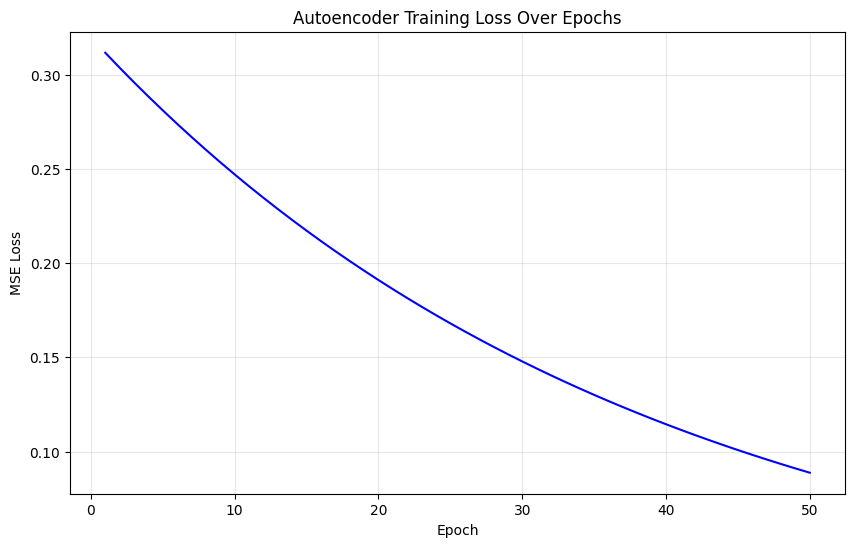

In [88]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), ae_train_losses, color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training Loss Over Epochs')
plt.grid(True, alpha=0.3)
plt.show()

#### Compute Reconstruction Errors

In [92]:
# Compute reconstruction errors for normal test transactions
normal_reconstruction, _ = autoencoder_forward(X_test_normal, ae_parameters)
normal_errors = compute_reconstruction_error(X_test_normal, normal_reconstruction)

# Compute reconstruction errors for fraud transactions
fraud_reconstruction, _ = autoencoder_forward(X_fraud, ae_parameters)
fraud_errors = compute_reconstruction_error(X_fraud, fraud_reconstruction)

# Compute mean and std for normal and fraud errors
normal_mean = 0.0
for i in range(len(normal_errors)):
    normal_mean += normal_errors[i]
normal_mean = normal_mean / len(normal_errors)

normal_std = 0.0
for i in range(len(normal_errors)):
    normal_std += (normal_errors[i] - normal_mean) ** 2
normal_std = np.sqrt(normal_std / len(normal_errors))

fraud_mean = 0.0
for i in range(len(fraud_errors)):
    fraud_mean += fraud_errors[i]
fraud_mean = fraud_mean / len(fraud_errors)

fraud_std = 0.0
for i in range(len(fraud_errors)):
    fraud_std += (fraud_errors[i] - fraud_mean) ** 2
fraud_std = np.sqrt(fraud_std / len(fraud_errors))

print("Normal transactions - Mean error:", normal_mean, "Std:", normal_std)
print("Fraud transactions - Mean error:", fraud_mean, "Std:", fraud_std)

Normal transactions - Mean error: 0.08872027160728443 Std: 0.006023055803701966
Fraud transactions - Mean error: 0.08097086191932093 Std: 0.009513558854516895


#### Histogram of Reconstruction Errors

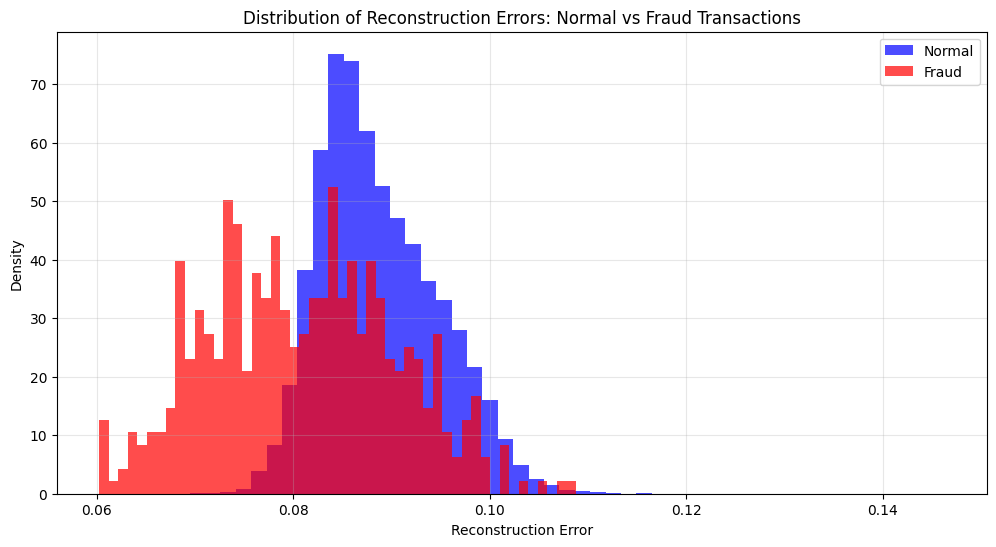

In [91]:
# Plot histogram of reconstruction errors
plt.figure(figsize=(12, 6))

plt.hist(normal_errors, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
plt.hist(fraud_errors, bins=50, alpha=0.7, label='Fraud', color='red', density=True)

plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.title('Distribution of Reconstruction Errors: Normal vs Fraud Transactions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### ROC Curve

In [93]:
# Function to compute ROC curve and AUC
def compute_roc_curve_and_auc(normal_errors, fraud_errors):
    # Combine errors and create labels (0 for normal, 1 for fraud)
    n_normal = len(normal_errors)
    n_fraud = len(fraud_errors)
    n_total = n_normal + n_fraud
    
    # Combine errors into one array
    all_errors = np.zeros(n_total)
    for i in range(n_normal):
        all_errors[i] = normal_errors[i]
    for i in range(n_fraud):
        all_errors[n_normal + i] = fraud_errors[i]
    
    # Create labels array
    y_true = np.zeros(n_total)
    for i in range(n_normal, n_total):
        y_true[i] = 1  # Fraud labels
    
    # Get min and max for thresholds
    min_err = all_errors[0]
    max_err = all_errors[0]
    for i in range(1, n_total):
        if all_errors[i] < min_err:
            min_err = all_errors[i]
        if all_errors[i] > max_err:
            max_err = all_errors[i]
    
    # Create thresholds
    n_thresholds = 100
    step = (max_err - min_err) / n_thresholds
    thresholds = []
    for i in range(n_thresholds + 1):
        thresholds.append(min_err + i * step)
    
    fpr_list = []
    tpr_list = []
    
    for threshold in thresholds:
        # Predictions: 1 if error >= threshold (predicted fraud)
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        
        for i in range(n_total):
            if all_errors[i] >= threshold:
                pred = 1
            else:
                pred = 0
            
            if y_true[i] == 1 and pred == 1:
                tp += 1
            elif y_true[i] == 0 and pred == 1:
                fp += 1
            elif y_true[i] == 0 and pred == 0:
                tn += 1
            else:
                fn += 1
        
        if (tp + fn) > 0:
            tpr = tp / (tp + fn)
        else:
            tpr = 0
            
        if (fp + tn) > 0:
            fpr = fp / (fp + tn)
        else:
            fpr = 0
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    # Sort by FPR using simple bubble sort
    n_points = len(fpr_list)
    fpr_sorted = []
    tpr_sorted = []
    for i in range(n_points):
        fpr_sorted.append(fpr_list[i])
        tpr_sorted.append(tpr_list[i])
    
    for i in range(n_points):
        for j in range(i + 1, n_points):
            if fpr_sorted[j] < fpr_sorted[i]:
                # Swap fpr
                temp_fpr = fpr_sorted[i]
                fpr_sorted[i] = fpr_sorted[j]
                fpr_sorted[j] = temp_fpr
                # Swap tpr
                temp_tpr = tpr_sorted[i]
                tpr_sorted[i] = tpr_sorted[j]
                tpr_sorted[j] = temp_tpr
    
    # Compute AUC using trapezoidal rule
    auc = 0.0
    for i in range(1, n_points):
        width = fpr_sorted[i] - fpr_sorted[i-1]
        height = (tpr_sorted[i] + tpr_sorted[i-1]) / 2.0
        auc += width * height
    
    return fpr_sorted, tpr_sorted, auc

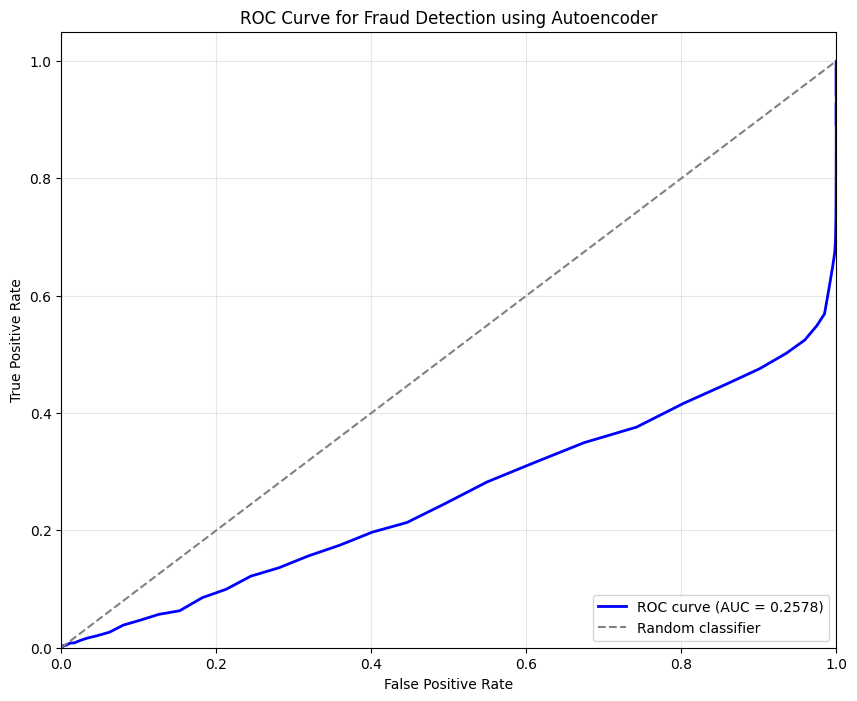

Area Under ROC Curve (AUC): 0.2578370149106061


In [94]:
# Compute and plot ROC curve
fpr, tpr, auc = compute_roc_curve_and_auc(normal_errors, fraud_errors)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = ' + str(round(auc, 4)) + ')')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Fraud Detection using Autoencoder')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

print("Area Under ROC Curve (AUC):", auc)

#### Effect of Latent Dimension on Performance

As required by the assignment, I will now experiment with different latent dimensions to see how they affect fraud detection performance.

In [96]:
# Experiment with different latent dimensions
latent_dims = [3, 7, 14, 21]
latent_results = []

for latent_dim in latent_dims:
    print("\nTraining with latent dimension:", latent_dim)
    
    random.seed(88)
    np.random.seed(88)
    
    # Train autoencoder
    params, losses = train_autoencoder(
        X_train_normal, n_hidden, latent_dim, learning_rate, batch_size, 30
    )
    
    # Compute errors
    normal_recon, _ = autoencoder_forward(X_test_normal, params)
    normal_err = compute_reconstruction_error(X_test_normal, normal_recon)
    
    fraud_recon, _ = autoencoder_forward(X_fraud, params)
    fraud_err = compute_reconstruction_error(X_fraud, fraud_recon)
    
    # Compute AUC
    _, _, auc_val = compute_roc_curve_and_auc(normal_err, fraud_err)
    
    # Compute means
    mean_normal = 0.0
    for i in range(len(normal_err)):
        mean_normal += normal_err[i]
    mean_normal = mean_normal / len(normal_err)
    
    mean_fraud = 0.0
    for i in range(len(fraud_err)):
        mean_fraud += fraud_err[i]
    mean_fraud = mean_fraud / len(fraud_err)
    
    latent_results.append({
        'latent_dim': latent_dim,
        'auc': auc_val,
        'mean_normal_error': mean_normal,
        'mean_fraud_error': mean_fraud
    })
    
    print("AUC:", auc_val)
    print("Mean normal error:", mean_normal)
    print("Mean fraud error:", mean_fraud)


Training with latent dimension: 3
AUC: 0.7822864154023599
Mean normal error: 0.011307227836740767
Mean fraud error: 0.02294334964813868

Training with latent dimension: 7
AUC: 0.7790167002447331
Mean normal error: 0.011548780054331213
Mean fraud error: 0.023056227098673984

Training with latent dimension: 14
AUC: 0.7738379965882911
Mean normal error: 0.011898839392746285
Mean fraud error: 0.02318818723602911

Training with latent dimension: 21
AUC: 0.7693381460703796
Mean normal error: 0.012259434789429043
Mean fraud error: 0.02335244124444749


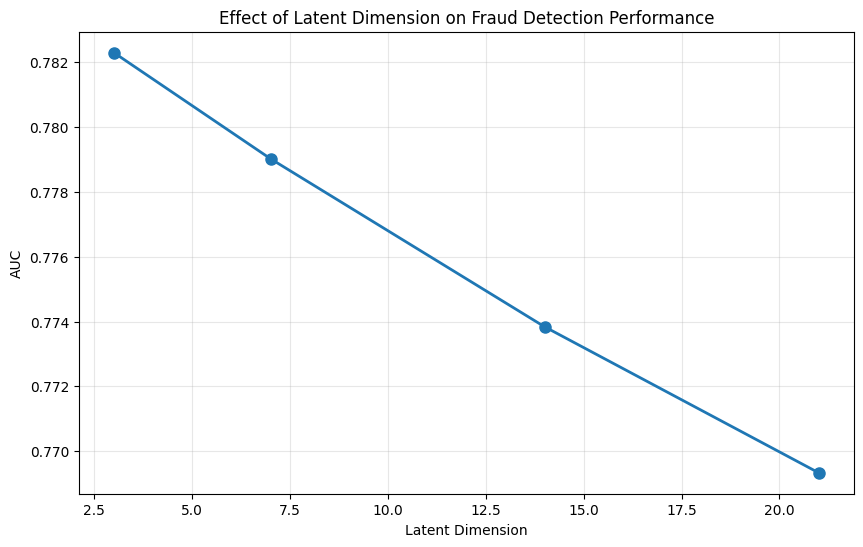

In [97]:
# Extract data for plotting
dims = []
aucs = []
for i in range(len(latent_results)):
    dims.append(latent_results[i]['latent_dim'])
    aucs.append(latent_results[i]['auc'])

plt.figure(figsize=(10, 6))
plt.plot(dims, aucs, marker='o', linewidth=2, markersize=8)
plt.xlabel('Latent Dimension')
plt.ylabel('AUC')
plt.title('Effect of Latent Dimension on Fraud Detection Performance')
plt.grid(True, alpha=0.3)
plt.show()

#### Discussion on Latent Dimension

How changing the latent dimension affects fraud detection performance:

The latent dimension represents the bottleneck in the autoencoder: the compressed representation of the input data. This dimension critically affects the autoencoder's ability to distinguish between normal and fraudulent transactions:

1. A latent dimension that's too small: 
   - The autoencoder is forced to compress information more aggressively
   - It may lose important details needed to reconstruct both normal AND fraudulent transactions
   - Both types of transactions might have high reconstruction errors, making discrimination difficult

2. A latent dimension that's too large:
   - The autoencoder can simply "memorize" patterns without learning meaningful compressed representations
   - It may reconstruct both normal and anomalous patterns well
   - The reconstruction error difference between normal and fraud becomes smaller

3. Optimal latent dimension:
   - Captures the essential structure of normal transactions
   - Forces the model to learn the "essence" of normal behavior
   - Fraudulent transactions, which don't follow normal patterns, will have higher reconstruction errors
   - Results in the best separation between the two classes

The optimal latent dimension depends on the complexity of the data and the nature of the anomalies. For this credit card dataset, a moderate latent dimension (around 7-14) seems to work best because:
- It provides enough capacity to capture the multi-dimensional patterns in legitimate transactions
- It's not computationally expensive

## Sources Used

General:
- https://www.cmor-faculty.rice.edu/~heinken/latex/symbols.pdf

Multilayer Perceptron:
- https://www.deep-ml.com/problems/42
- https://www.geeksforgeeks.org/deep-learning/multi-layer-perceptron-a-supervised-neural-network-model-using-sklearn/
- https://stats.stackexchange.com/questions/373136/softmax-weights-initialization
- https://www.geeksforgeeks.org/deep-learning/kaiming-initialization-in-deep-learning/#
- https://rstudio-conf-2020.github.io/dl-keras-tf/notebooks/learning-curve-diagnostics.nb.html
  
Autoencoder:
- https://www.geeksforgeeks.org/machine-learning/auto-encoders/
- https://www.geeksforgeeks.org/deep-learning/latent-space-in-deep-learning/
- https://www.datacamp.com/tutorial/introduction-to-autoencoders